# Install Dependencies

In [1]:
!pip3 install stable-baselines3 gym-anytrading gymnasium tensorflow

  Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached tensorflow_metal-1.1.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (1.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.3 MB/s eta 0:00:00
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-16.0.6-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-4.25.1-cp3

# Install MacOS Dependencies

In [2]:
!pip3 install tensorflow-macos tensorflow-metal

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import Dependencies

In [13]:
import gymnasium as gym
import gym_anytrading

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Import Trading Data

In [4]:
# CSV downloaded from: https://www.marketwatch.com/investing/stock/cfg/download-data
df = pd.read_csv('data/Download Data - STOCK_US_XNYS_CFG.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,12/11/2023,29.40,29.79,29.16,29.59,"3,222,813"
1,12/08/2023,29.33,29.90,29.12,29.61,"4,002,800"
2,12/07/2023,28.93,29.35,28.78,29.16,"3,254,849"
3,12/06/2023,29.40,30.07,28.72,28.76,"6,707,243"
4,12/05/2023,28.33,29.33,28.19,29.06,"9,472,810"


# Clean Trading Data

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-12-11,29.40,29.79,29.16,29.59,"3,222,813"
2023-12-08,29.33,29.90,29.12,29.61,"4,002,800"
2023-12-07,28.93,29.35,28.78,29.16,"3,254,849"
2023-12-06,29.40,30.07,28.72,28.76,"6,707,243"
2023-12-05,28.33,29.33,28.19,29.06,"9,472,810"


# Build Environment

info {'total_reward': 10.460002899169922, 'total_profit': 0.6848333438517127, 'position': <Positions.Short: 0>}


/Users/nickgagne/Development/stock-ai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_all` for environment variables or `env.get_wrapper_attr('render_all')` that will search the reminding wrappers.
  logger.warn(


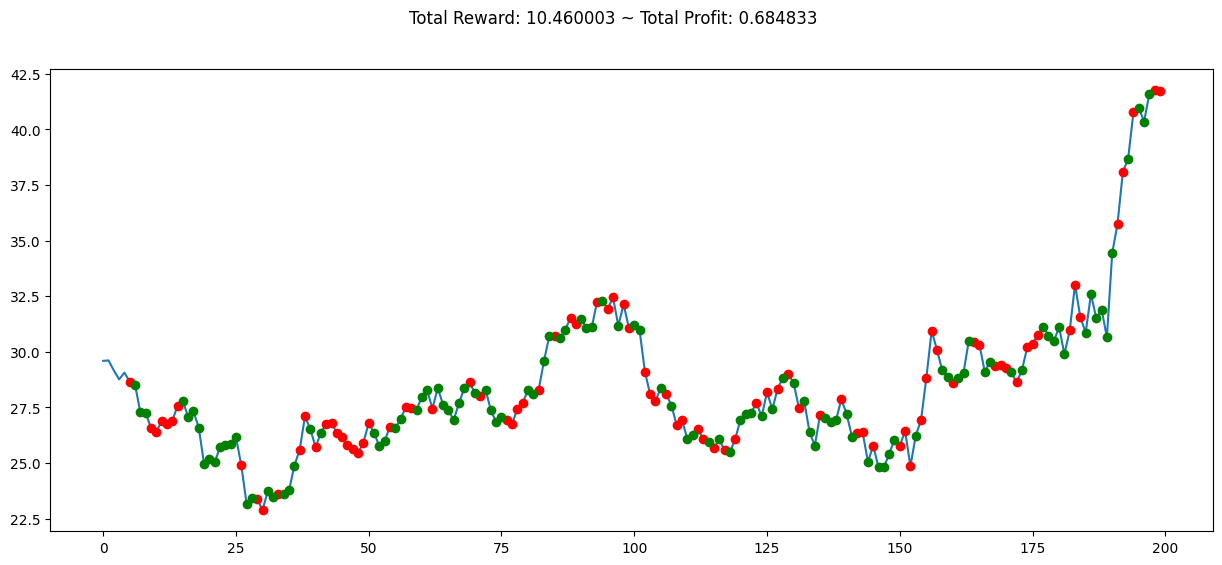

In [6]:
env = gym.make('stocks-v0', df=df, frame_bound=(5, 200), window_size=5)
obs = env.reset()
while True:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Train Model Against a Subset of the Data

In [21]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5, 200), window_size=5)
env = DummyVecEnv([env_maker])

# model = A2C('MlpPolicy', env, verbose=1)
model = PPO('MlpPolicy', env, verbose=1, device="auto")
model.learn(total_timesteps=100000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5470 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3631        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015173101 |
|    clip_fraction        | 0.0446      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | -0.0132     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.47        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00344    |
|    value_loss           | 3.09        |
-----------------------------------------
-----------------

# Test Model Against The Remaining Subset of Data

info {'total_reward': 0.0, 'total_profit': 0.9373597953018723, 'position': <Positions.Long: 1>}


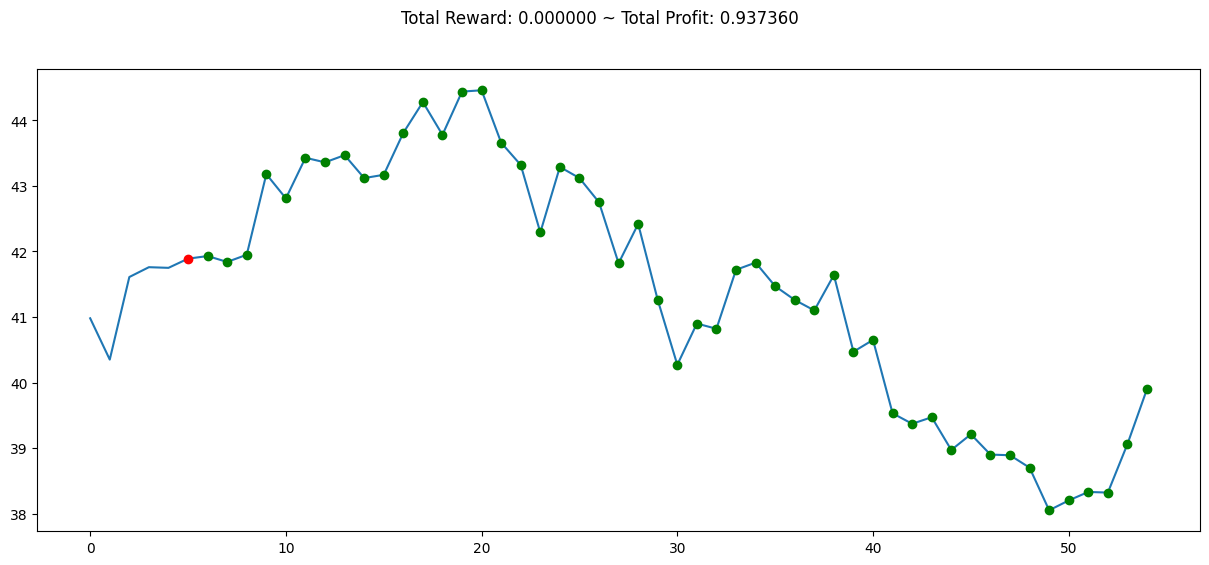

In [24]:
env = gym.make('stocks-v0', df=df, frame_bound=(200, 250), window_size=5)
obs, _ = env.reset()

while True:
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()